In [1]:
#!pip install pytorch-fid

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
import math
#from pytorch_fid.fid_score import calculate_fid_given_paths

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
BATCH_SIZE = 128


def corrupt(x, amount):
    noise = 2 * torch.rand_like(x) - 1 
    amount = amount.view(-1, 1, 1, 1)
    return x*(1-amount) + noise*amount


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Using device: cuda


In [4]:
train_data_dir = "/kaggle/input/traffic-32/trafic_32"

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

x, y = next(iter(train_loader))
print('Input shape:', x.shape)
print('Labels:', y)

Input shape: torch.Size([128, 3, 32, 32])
Labels: tensor([ 4, 10,  1,  9, 13,  2, 26, 40, 19,  9,  4,  5, 11,  5,  2, 17, 32,  5,
         1,  4, 18,  5, 13,  9, 18,  2,  5, 10,  4, 10, 10,  3, 40,  2,  3, 38,
         3,  4, 22, 16, 35, 11,  4, 19, 25, 10, 13, 35, 17, 29, 11, 37, 31, 33,
         9, 38,  5,  2, 36,  4,  5,  5, 13, 13, 35, 14, 15,  2, 17, 18, 42, 19,
         7, 38,  4,  2, 34,  0, 36,  7, 41,  4, 15, 35, 13, 36, 11,  5, 12, 14,
        13,  7, 15,  9, 36,  7, 18, 13, 12, 36, 23,  3,  2, 12, 12, 30, 38, 35,
         1, 26,  1,  2, 38,  2, 23,  5, 28, 33, 33, 31, 10, 22, 28, 21,  4, 25,
        23, 12])


In [5]:
from PIL import Image
image_path = "/kaggle/input/traffic-32/trafic_32/00000/00000_00000/00000_00000.jpg"
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.ToTensor(),
])

image_tensor = transform(image)

print("Min wartość piksela:", torch.min(image_tensor))
print("Max wartość piksela:", torch.max(image_tensor))

Min wartość piksela: tensor(0.)
Max wartość piksela: tensor(1.)


Input shape: torch.Size([128, 3, 32, 32])
Labels: tensor([34, 15, 28,  3, 13, 12, 36, 35,  9, 13, 42,  9, 35, 31, 18,  2, 10, 35,
         8, 18,  8, 13, 23, 35, 10,  7, 17, 41, 35,  2, 42, 23, 12, 13,  4, 30,
         5,  8,  4,  9, 12,  1,  2, 38, 19, 33, 29,  8,  4, 38,  7, 34, 14, 13,
        20, 40, 14,  3, 38, 26, 13, 13,  4,  4, 12,  1, 25,  7,  4, 12, 10, 13,
         5,  5, 16, 33,  1, 38, 35, 11, 39, 17,  4,  1, 18, 18, 32,  8, 18, 34,
        25, 38, 19, 35,  4, 16, 11, 12,  7, 35, 40, 39, 14,  4, 15,  7, 36, 24,
         7, 28, 22,  7,  8, 18, 11,  5, 11,  2,  6,  5,  2, 33,  8,  8, 17,  1,
        15,  2])


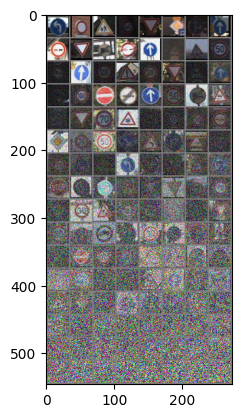

In [6]:
x, y = next(iter(train_loader))
print('Input shape:', x.shape)
print('Labels:', y)

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)
imshow(torchvision.utils.make_grid(noised_x))

In [7]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, num_classes, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.class_embedding = nn.Embedding(num_classes, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t, label):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2]
        # Class embedding
        class_emb = self.class_embedding(label)
        class_emb = class_emb[(...,) + (None,) * 2]
        # Add time channel and class channel
        h = h + time_emb + class_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)


class BasicUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """

    def __init__(self, num_classes):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 1

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim, num_classes) \
                                    for i in range(len(down_channels) - 1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, num_classes, up=True) \
                                  for i in range(len(up_channels) - 1)])

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep, label):
        t = timestep.unsqueeze(-1)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t, label)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t, label)
        return self.output(x)

In [8]:
n_epochs = 100
num_classes = 43
net = BasicUnet(num_classes)
net.to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-5)
losses = []

for epoch in range(n_epochs):
    for x, y in train_loader:
        if len(x) != 128:
            continue
        x = x.to(device)
        labels = y.to(device)
        t = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, t)

        # Get the model prediction
        pred = net(noisy_x, t, labels)


        # Calculate the loss
        loss = loss_fn(pred, x)

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_loader):]) / len(train_loader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

Finished epoch 0. Average loss for this epoch: 0.235949
Finished epoch 1. Average loss for this epoch: 0.154634
Finished epoch 2. Average loss for this epoch: 0.105461
Finished epoch 3. Average loss for this epoch: 0.070074
Finished epoch 4. Average loss for this epoch: 0.056234
Finished epoch 5. Average loss for this epoch: 0.052589
Finished epoch 6. Average loss for this epoch: 0.050094
Finished epoch 7. Average loss for this epoch: 0.048922
Finished epoch 8. Average loss for this epoch: 0.047494
Finished epoch 9. Average loss for this epoch: 0.046564
Finished epoch 10. Average loss for this epoch: 0.045651
Finished epoch 11. Average loss for this epoch: 0.044223
Finished epoch 12. Average loss for this epoch: 0.043345
Finished epoch 13. Average loss for this epoch: 0.042379
Finished epoch 14. Average loss for this epoch: 0.043482
Finished epoch 15. Average loss for this epoch: 0.042137
Finished epoch 16. Average loss for this epoch: 0.041351
Finished epoch 17. Average loss for this 

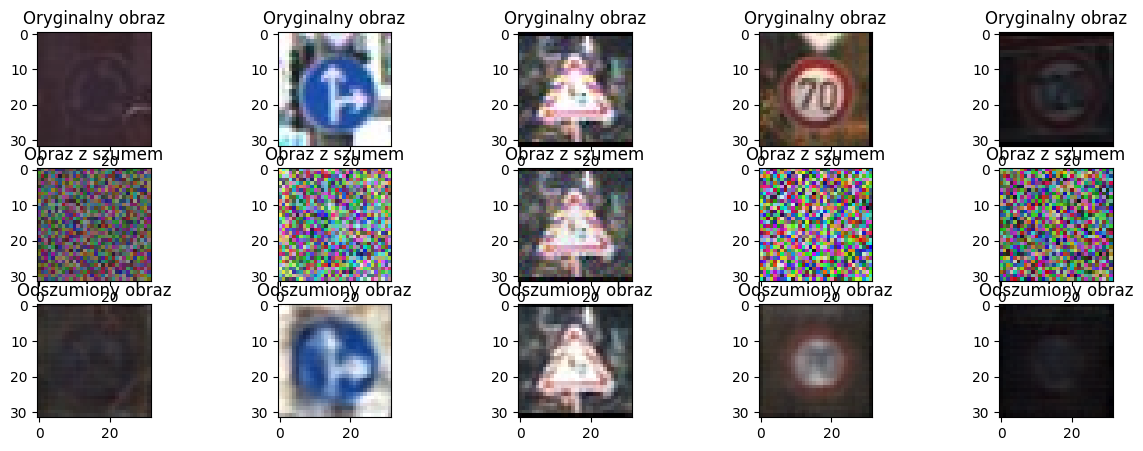

In [9]:
def imshowTitle(img, title):
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)

x_original, y = next(iter(train_loader)) 
amount_of_noise = torch.rand(x_original.shape[0]).to(device)
x_with_noise = corrupt(x_original.to(device), amount_of_noise)
labels = y.to(device)

with torch.no_grad():
    denoised_output = net(x_with_noise, amount_of_noise, labels)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(3, 5, i + 1)
    imshowTitle(x_original[i], title='Oryginalny obraz')
    plt.subplot(3, 5, i + 6)
    imshowTitle(x_with_noise[i], title='Obraz z szumem')
    plt.subplot(3, 5, i + 11)
    imshowTitle(denoised_output[i], title='Odszumiony obraz')
plt.show()

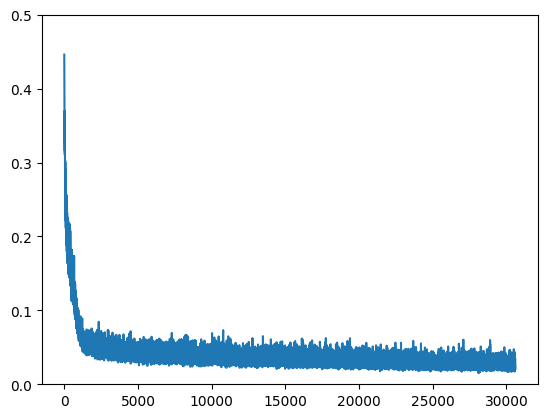

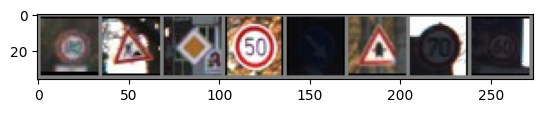

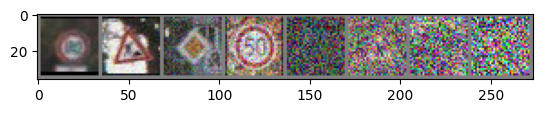

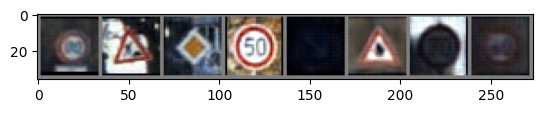

In [10]:
plt.plot(losses)
plt.ylim(0, 0.5)
plt.show()


x, y = next(iter(train_loader))
x = x[:8]
y = y[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)
labels = y.to(device)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device), amount.to(device), labels).detach().cpu()

# Plot
imshow(torchvision.utils.make_grid(x))
imshow(torchvision.utils.make_grid(noised_x))
imshow(torchvision.utils.make_grid(preds))

In [11]:
from collections import Counter

num_images = 1000

class_counts = Counter(train_dataset.targets)
total_samples = len(train_dataset)
class_probabilities = {cls: count / total_samples for cls, count in class_counts.items()}

labels = torch.tensor([torch.multinomial(torch.tensor(list(class_probabilities.values())), 1).item() for _ in range(num_images)], device=device)

In [12]:
n_steps = 100
x = (torch.rand(num_images, 3, 32, 32) * 2 - 1).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []


for i in range(n_steps):
    t = (torch.zeros(x.size(0)) + (n_steps - i)/n_steps).to(device)
    with torch.no_grad():
        pred = net(x, t, labels)
    pred_output_history.append(pred.detach().cpu())
    
#     mix_factor = 1/(n_steps - i)
#     x = x*(1-mix_factor) + pred*mix_factor
#     step_history.append(x.detach().cpu())
    noise = torch.rand_like(x).to(device) * 2 - 1
    
    mix_factor = 1/(n_steps - i)
    x = noise * mix_factor + pred * (1 - mix_factor)  
    step_history.append(x.detach().cpu())

# for i in range(n_steps):
#     imshow(torchvision.utils.make_grid(step_history[i]))
#     imshow(torchvision.utils.make_grid(pred_output_history[i]))

(array([4.00000e+00, 1.20000e+01, 1.10000e+01, 3.00000e+01, 6.60000e+01,
        8.30000e+01, 1.62000e+02, 3.20000e+02, 5.36000e+02, 9.38000e+02,
        1.47300e+03, 2.40500e+03, 3.60200e+03, 5.41200e+03, 7.76300e+03,
        1.11710e+04, 1.53880e+04, 2.11370e+04, 2.79860e+04, 3.72810e+04,
        4.75740e+04, 5.97070e+04, 7.25060e+04, 8.46080e+04, 9.39720e+04,
        1.02865e+05, 1.10317e+05, 1.14216e+05, 1.17051e+05, 1.18081e+05,
        1.17675e+05, 1.16494e+05, 1.14454e+05, 1.10112e+05, 1.06798e+05,
        1.03115e+05, 9.88650e+04, 9.43010e+04, 8.97070e+04, 8.48120e+04,
        8.01650e+04, 7.53360e+04, 7.06630e+04, 6.58910e+04, 6.19710e+04,
        5.74220e+04, 5.31910e+04, 4.94710e+04, 4.54090e+04, 4.23350e+04,
        3.83210e+04, 3.54120e+04, 3.29220e+04, 2.96070e+04, 2.73310e+04,
        2.50180e+04, 2.25380e+04, 2.05200e+04, 1.82540e+04, 1.63670e+04,
        1.47300e+04, 1.33810e+04, 1.16660e+04, 1.02650e+04, 9.04400e+03,
        7.90000e+03, 6.96400e+03, 5.89500e+03, 5.04

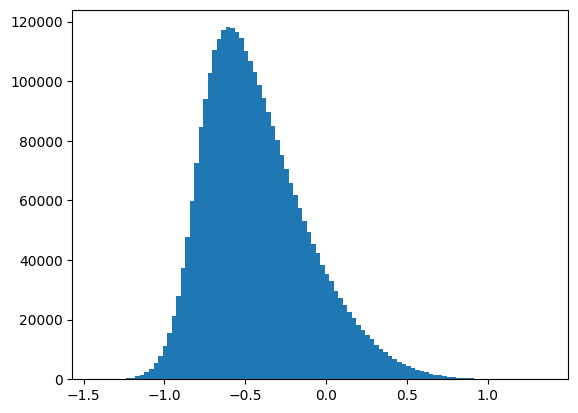

In [13]:
plt.hist(pred_output_history[0].flatten().detach().numpy(), bins=100)

In [14]:
generated_imgs = torch.stack([pred_output_history[-1][j] for j in range(num_images)])
torch.save(generated_imgs.cpu().detach(), "poniedzialek_Pawlak_Tomczykowski.pt")

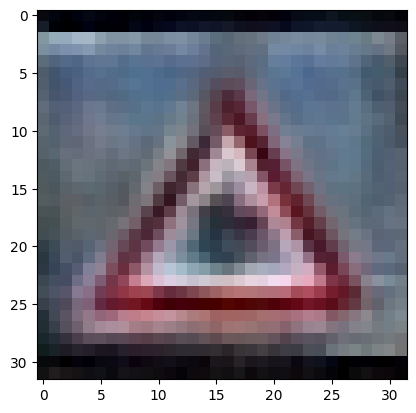

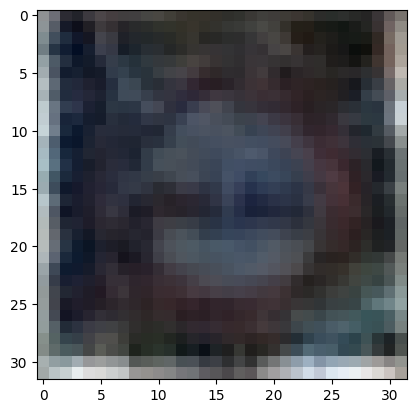

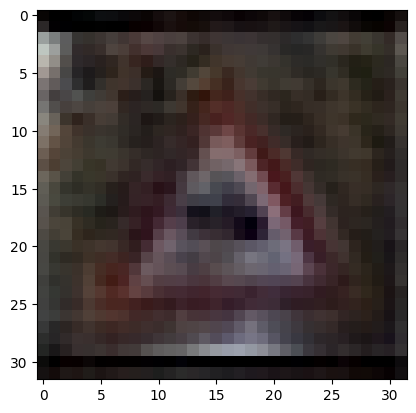

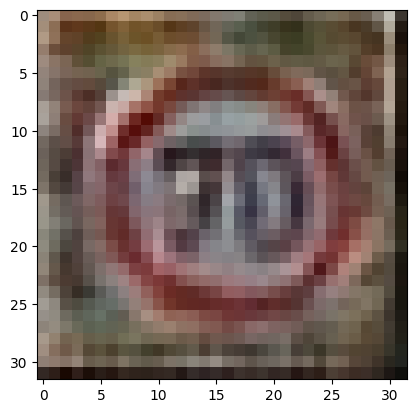

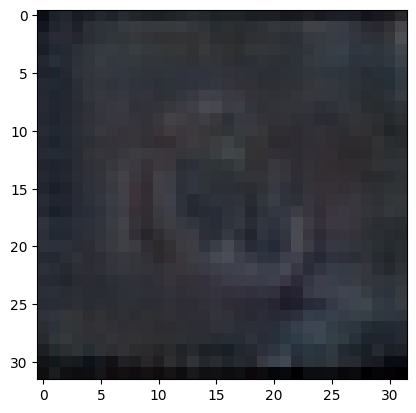

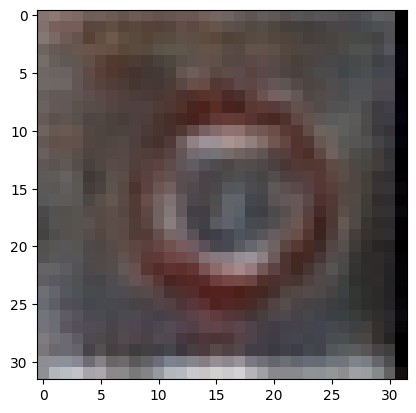

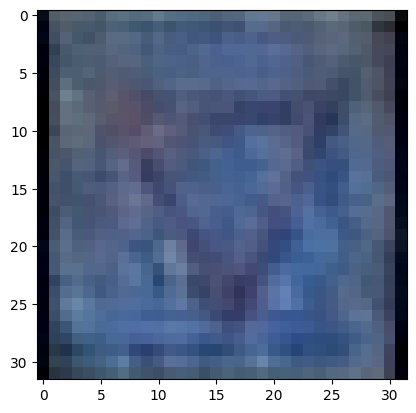

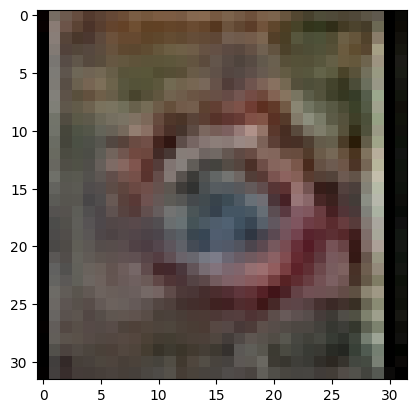

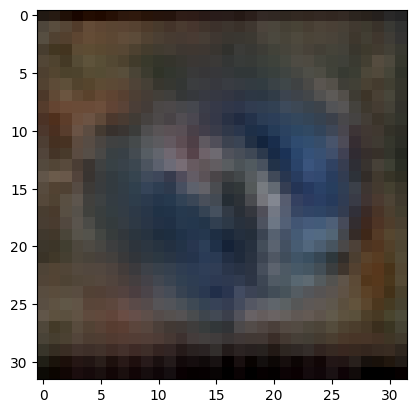

In [15]:
img_from_file = "/kaggle/working/poniedzialek_Pawlak_Tomczykowski.pt"
load = torch.load(img_from_file)
i = 0
for img in load:
    i += 1
    if i == 10:
        break
    imshow(img)